<a href="https://colab.research.google.com/github/paulxiong/ai-challenge-mars/blob/master/Cell_image_completion_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Dataset


In [92]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
GPATH="/content/gdrive/My Drive/aiml/OmdenaMars/"

import os
GPATH="/content/gdrive/My Drive/aiml/OmdenaMars/"
os.environ["GPATH"] = GPATH


Mounted at /content/gdrive


In [93]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
BASE_PATH="/content/data/"
os.environ["BASE_PATH"] = BASE_PATH

TRAIN_PATH=BASE_PATH+"train/"
os.environ["TRAIN_PATH"] = TRAIN_PATH

TEST_PATH=BASE_PATH+"test/"
os.environ["TEST_PATH"] = TEST_PATH

TMP_PATH=BASE_PATH+"tmp/"
os.environ["TMP_PATH"] = TEST_PATH

WEIGHTS_PATH=GPATH+"weights/image-completion-0919/"
os.environ["WEIGHTS_PATH"] = WEIGHTS_PATH


In [0]:
import pathlib
from shutil import copyfile
import os
import pandas as pd

pathlib.Path(TRAIN_PATH).mkdir(parents=True, exist_ok=True)
pathlib.Path(TMP_PATH).mkdir(parents=True, exist_ok=True)
pathlib.Path(WEIGHTS_PATH).mkdir(parents=True, exist_ok=True)

if not os.path.isfile(BASE_PATH+"natural.tgz"):
    print("Copying natural.tgz to local folder")
    copyfile(GPATH+"natural.tgz", BASE_PATH+"natural.tgz")
if not os.path.isfile(BASE_PATH+"techno.tgz"):
    print("Copying techno.tgz to local folder")
    copyfile(GPATH+"techno.tgz", BASE_PATH+"techno.tgz")

Extract "techno signature" files to test path

In [96]:
!rm -rf /content/data/test
!echo "Extracting techno.tgz"
!tar -xzf "$BASE_PATH""techno.tgz" -C $TMP_PATH
!echo "Copying Techno folder as test"
#boostx : remake the test path with techno
#!cp -r "/content/data/tmp/content/gdrive/My Drive/aiml/OmdenaMars/data/techno" "$TEST_PATH"
!cp -r "/content/data/tmp/content/gdrive/My Drive/aiml/OmdenaMars/data" "$TEST_PATH"

Extracting techno.tgz
Copying Techno folder as test


Extract natural files with out black borders to train path.

In [97]:
import shutil

!rm -rf /content/data/train
!mkdir /content/data/train
!echo "Extracting natural.tgz"
!tar -xzf "$BASE_PATH""natural.tgz" -C $TMP_PATH
#boostx : don't know why the system add some .xxx.png files, so delete it.
!rm -rf /content/data/train/._*
!rm -rf /content/data/train/.DS_Store
#boostx : end

print("Moving Natural File")
count = 204800
for file in os.listdir(TMP_PATH+"content/gdrive/My Drive/aiml/OmdenaMars/data/natural/"):
  #boostx : don't check the coodinations 
  #  f1 = file.split("_")
  #  xVal = int(f1[2])
  #  yVal = int(f1[4].split(".")[0])
  #  if (xVal >= 8000) and (yVal>=5000):
  #      if(xVal <= 15000) and (yVal <= 30000):
  #boostx : end
            shutil.move(TMP_PATH+"content/gdrive/My Drive/aiml/OmdenaMars/data/natural/"+file, TRAIN_PATH+file)
            count -= 1
            if (count <= 0):
                break

Extracting natural.tgz
Moving Natural File


In a production data set anomalies are already mixed with natural images. So lets copy anomaly images also to natural images and train on this data set.

In [98]:
import shutil
import os
from PIL import Image

#boostx : add natural data to TESTPATH
!rm -rf /content/data/test/natural
!mkdir /content/data/test/natural
! cp /content/data/train/*.*  /content/data/test/natural/

for dir in os.listdir(TMP_PATH+"content/gdrive/My Drive/aiml/OmdenaMars/data/techno/"):
    #boostx : don't know why there is ._9, just ignore it.
    if dir == '._9' or dir == '.DS_Store':
      print(str(dir))
      break;
    #boostx : end
    print("Moving Files from:", dir+":")
    for file in os.listdir(TMP_PATH+"content/gdrive/My Drive/aiml/OmdenaMars/data/techno/"+dir):
        #print(file)
        shutil.copy(TMP_PATH+"content/gdrive/My Drive/aiml/OmdenaMars/data/techno/"+dir+"/"+file, TRAIN_PATH+file)


Moving Files from: 7:


In [99]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

train_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    directory   = BASE_PATH,       # this is the target directory
    target_size = (128, 128, 1)[:-1],    # all images will be resized to 64x64
    batch_size  = 128,
    color_mode  = "grayscale",           # We use a grayscale dataset
    classes=["train"],
    class_mode  = None                   # We do not need to get any label => Everything is healthy
)  

#train_generator.next()

Found 3471 images belonging to 1 classes.


# AnomalyDetector

## Common Imports

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, Conv1D, UpSampling2D
from keras.backend import clip
from keras.initializers import RandomNormal
from keras.optimizers import Adam

from keras.constraints import Constraint
from keras import backend as K

import tensorflow as tf

import numpy as np
import csv

from keras.utils. generic_utils import Progbar



## Common Defines

In [0]:
BATCH_SIZE = 128
IMAGE_SIZE = 128
#boostx : use 128 instead of 32
MASK_SIZE = 128
#MASK_SIZE = 128
#boostx end
LAMBDA = 0.9

SAVE_EVERY_EPOCH = 5
TEST_EVERY_EPOCH = 5

In [0]:
#from: https://stackoverflow.com/questions/42264567/keras-ml-library-how-to-do-weight-clipping-after-gradient-updates-tensorflow-b
class WeightClip(Constraint):
    '''Clips the weights incident to each hidden unit to be inside a range
    '''
    def __init__(self, c=1):
        self.c = c

    def __call__(self, p):
        return K.clip(p, -self.c, self.c)

    def get_config(self):
        return {'name': self.__class__.__name__,
                'c': self.c}


def defineModel():
    
    kernelInitializer = RandomNormal(mean=0.0, stddev=1, seed=None)

    #where Conv(k; d; s; c) denotes a convolutional layer with kernel size k x k, dilation rate d, stride s and c output channels.
    model = Sequential()

    #Conv(5; 1; 1; 32)
    model.add(Conv2D(input_shape = (128,128,1), 
                     filters=32, kernel_size=5, dilation_rate=1, strides=1, padding="same", activation="elu"))

    #Conv(3; 1; 1; 64)
    model.add(Conv2D(filters=64, kernel_size=3, dilation_rate=1, strides=1, padding="same", activation="elu"))

    #Conv(3; 1; 1; 64)
    model.add(Conv2D(filters=64, kernel_size=3, dilation_rate=1, strides=1, padding="same", activation="elu"))

    #Conv(3; 1; 2; 128)
    model.add(Conv2D(filters=128, kernel_size=3, dilation_rate=1, strides=2, padding="same", activation="elu"))

    #Conv(3; 1; 1; 128)
    model.add(Conv2D(filters=128, kernel_size=3, dilation_rate=1, strides=1, padding="same", activation="elu"))

    #Conv(3; 1; 1; 128)
    model.add(Conv2D(filters=128, kernel_size=3, dilation_rate=1, strides=1, padding="same", activation="elu"))

    #Conv(3; 2; 1; 128)
    model.add(Conv2D(filters=128, kernel_size=3, dilation_rate=2, strides=1, padding="same", activation="elu"))

    #Conv(3; 4; 1; 128)
    model.add(Conv2D(filters=128, kernel_size=3, dilation_rate=4, strides=1, padding="same", activation="elu"))

    #Conv(3; 8; 1; 128)
    model.add(Conv2D(filters=128, kernel_size=3, dilation_rate=8, strides=1, padding="same", activation="elu"))

    #Conv(3; 16; 1; 128)
    model.add(Conv2D(filters=128, kernel_size=3, dilation_rate=16, strides=1, padding="same", activation="elu"))
    #model.add(Conv2D(filters=128, kernel_size=3, dilation_rate=8, strides=1))

    #Conv(3; 1; 1; 128)
    model.add(Conv2D(filters=128, kernel_size=3, dilation_rate=1, strides=1, padding="same", activation="elu"))

    #Conv(3; 1; 1; 128)
    model.add(Conv2D(filters=128, kernel_size=3, dilation_rate=1, strides=1, padding="same", activation="elu"))

    #Bilinear Upscaling(2x)
    model.add(UpSampling2D(size=2, interpolation="bilinear"))

    #Conv(3; 1; 1; 64)
    model.add(Conv2D(filters=64, kernel_size=3, dilation_rate=1, strides=1, padding="same", activation="elu"))

    #Conv(3; 1; 1; 64)
    model.add(Conv2D(filters=32, kernel_size=3, dilation_rate=1, strides=1, padding="same", activation="elu"))

    #Conv(3; 1; 1; 32)
    model.add(Conv2D(filters=32, kernel_size=3, dilation_rate=1, strides=1, padding="same", activation="elu"))

    #Conv(3; 1; 1; 16)
    model.add(Conv2D(filters=16, kernel_size=3, dilation_rate=1, strides=1, padding="same", activation="elu"))

    #Conv(3; 1; 1; 1) + Clip(-1; 1)
    model.add(Conv2D(filters=1, kernel_size=3, dilation_rate=1, strides=1, padding="same", W_constraint = WeightClip(1), activation="elu"))

    return model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=1, kernel_size=3, dilation_rate=1, strides=1, padding="same", activation="elu", kernel_constraint=<__main__....)`


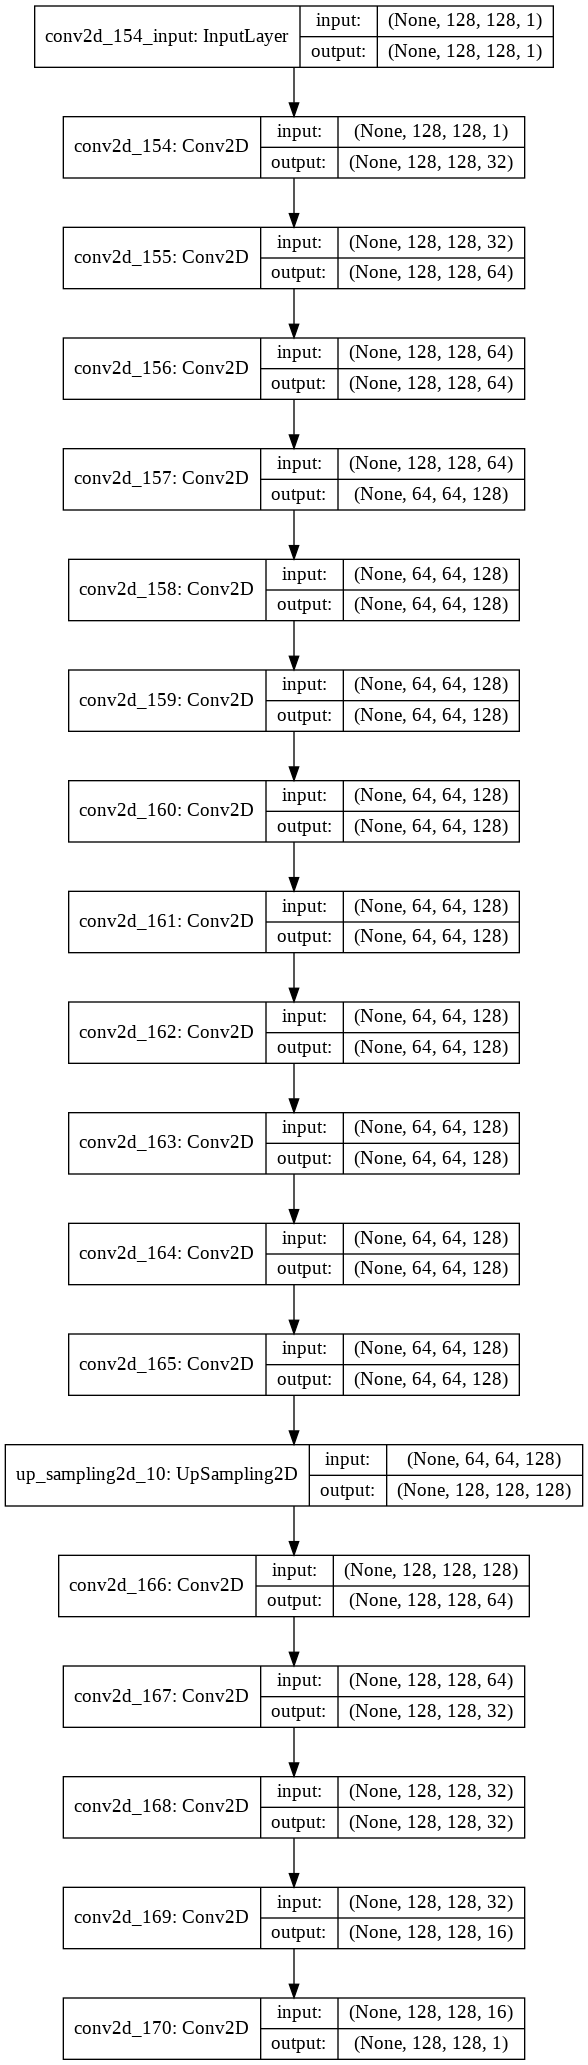

In [103]:
from keras.utils import plot_model, vis_utils
from IPython.display import Image
from IPython.display import display

import IPython

model = defineModel()
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
display(Image(retina=True,filename='model.png'))


In [0]:
import keras.backend as K
import tensorflow as tf 


def getMaskArray(aSize, mSize):
    m = np.ones((aSize, aSize))
    haSize = int(aSize/2)
    hmSize = int(mSize/2)
    m[haSize-hmSize:haSize+hmSize, haSize-hmSize:haSize+hmSize] = 0
    return m


def getLoss(aSize, mSize):
    
    m1 = getMaskArray(aSize,mSize)
    m2 = np.repeat(m1[np.newaxis, :, :, np.newaxis], BATCH_SIZE, axis=0)
    mask = K.variable(m2)
    invMask = K.variable(1-mask)
    imgSize = K.variable(IMAGE_SIZE)
    batchSize = K.variable(BATCH_SIZE)
    lam = K.variable(LAMBDA)
    def anoLoss(y_true, y_pred):
        d1 = tf.math.multiply(mask, (y_true - tf.math.multiply(invMask,y_pred)))
        d2 = tf.math.multiply(invMask, (y_true - tf.math.multiply(invMask,y_pred)))
        #v1 = (lam*tf.norm(d1,ord=1))/(imgSize*imgSize)
        #v2 = (lam*tf.norm(d2,ord=1))/(imgSize*imgSize)
        v1 = (lam*tf.norm(d1,ord=1))
        v2 = (lam*tf.norm(d2,ord=1))
        r = (v1+v2)/batchSize
        #d = tf.Print(r, [r], "Inside loss function")
        return r
        
    return anoLoss



In [108]:
model = defineModel()

#ADAM optimizer 
adam = Adam(lr=0.0002, beta_1=0.9, beta_2=0.999, epsilon=pow(10,-8))

model.compile(optimizer=adam,
              loss=getLoss(IMAGE_SIZE,MASK_SIZE)) # Call the loss function with the selected layer

#model.compile(optimizer="adam",
#              loss="mse",
#              metrics=['accuracy'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=1, kernel_size=3, dilation_rate=1, strides=1, padding="same", activation="elu", kernel_constraint=<__main__....)`


In [123]:
#boostx : don't know why the system add some .xxx.png files, so delete it.
!rm -rf /content/data/train/._*
#boostx : end



X_train_generator = train_generator
batch_size = X_train_generator.batch_size        
n_steps = int(X_train_generator.samples / batch_size)

mask = getMaskArray(IMAGE_SIZE, MASK_SIZE)
#invMask = 1-mask
mulMask = np.repeat(mask[np.newaxis, :, :, np.newaxis], BATCH_SIZE, axis=0)


SAVE_EVERY_EPOCH=5
reloadWeights = True
maxEpoch = 50
field_names = ['epoch', 'file-name','loss']
_lastEpoch = 0

#Initialize train status file
if (not os.path.isfile(WEIGHTS_PATH+"train-status.csv")) or (reloadWeights == False):
    with open(WEIGHTS_PATH+"train-status.csv","w") as trainStatusFile:
        tStatusLogger = csv.DictWriter(trainStatusFile, fieldnames=field_names)
        tStatusLogger.writeheader()
else:
    df = pd.read_csv(WEIGHTS_PATH+"train-status.csv")
    if df.shape[0] > 0:
        _lastEpoch = df["epoch"].iloc[-1]
        lastFileName = df["file-name"].iloc[-1]
        print("Last Completed Epoch:", _lastEpoch)
        print("Loading Weights from:", lastFileName)
        model.load_weights(WEIGHTS_PATH+lastFileName)

_lastEpoch += 1
for epoch in range(_lastEpoch, maxEpoch+1):
    print("Epoch:", epoch)
    n_iter = int(X_train_generator.samples / BATCH_SIZE)
    progress_bar = Progbar(target=n_iter)
    lossHist = []
    for index in range(n_iter):
        #boostx : don't know why the system add some .xxx.png files, so delete it.
        #print("boostx :"+str(index))
        try:
          image_batch = (X_train_generator.next().astype(np.float32) - 127.5) / 127.5
          if (image_batch.shape[0] != BATCH_SIZE):
              #Incomplete last batch, skip to next batch
              image_batch = (X_train_generator.next().astype(np.float32) - 127.5) / 127.5
          
          #image_batch = image_batch[:,:,:,0]
          masked_batch = np.multiply(image_batch,mulMask)
          X = masked_batch
          y = image_batch
          lossVal = model.train_on_batch(X,y)
          progress_bar.update(index+1, values=[(model.metrics_names[0],lossVal)])
          lossHist.append(lossVal)
        except Exception as e:
          print(str(e))

        #boostx : end  
    if epoch % SAVE_EVERY_EPOCH == 0:
        fileName = WEIGHTS_PATH+'model.epoch-{}.h5'.format(epoch)
        print("\nSaving Weights to:", fileName)
        model.save_weights(fileName, True)
        
        tStatus = {}
        tStatus['epoch'] = epoch
        tStatus['file-name'] = os.path.basename(fileName)
        tStatus['loss'] = round(sum(lossHist)/len(lossHist),4)

        with open(WEIGHTS_PATH+"train-status.csv","a") as trainStatusFile:
            tStatusLogger = csv.DictWriter(trainStatusFile, fieldnames=field_names)
            tStatusLogger.writerow(tStatus)
            

#model.fit_generator(generator=train_generator,steps_per_epoch=128)


Last Completed Epoch: 55
Loading Weights from: model.epoch-55.h5


In [0]:
import cv2
from numpy import newaxis
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

def anomalyScore(y_true, y_pred):
    mask = getMaskArray(IMAGE_SIZE, 24)
    invMask = 1-mask
    y_masked_true = np.multiply(y_true, mask)
    y_masked_pred = np.multiply(y_pred, mask)
    diff = ((y_masked_true-y_masked_pred)**2).mean()
    return diff

def testModel(model, dir):
    #boostx : train_directory not defined error, define here, use the training directory fist. 
    train_directory=TEST_PATH
    #boostx : end 
    folder=train_directory+dir

    files = []
    scores = [] 
    mask = getMaskArray(IMAGE_SIZE, MASK_SIZE)
    invMask = 1-mask
    mulMask = invMask[:, :, np.newaxis]

    for filename in tqdm(os.listdir(folder)):
        img = cv2.imread(os.path.join(folder,filename),0)
        #boostx : to avoid broken image error
        #print(str(filename))
        try:
          img = cv2.resize(img,(128,128))
          imgScaled = (img.astype(np.float32) - 127.5) / 127.5
          imgScaled = np.array([imgScaled])
          imgScaled = imgScaled[:,:,:,newaxis]
          imgMasked = np.multiply(imgScaled,mulMask)
          imgPredict = model.predict(imgMasked)
          score = anomalyScore(imgMasked, imgPredict)
          files.append(filename)
          scores.append(score)
        except Exception as e:
          print(str(e))
        #boost x end
        #plt.imshow(img, cmap='gray')
        #plt.imshow(im3[0,:,:,0], cmap='gray')
        #plt.imshow(imgPredict[0,:,:,0], cmap='gray')
        #plt.show()
    return pd.DataFrame({'files':files, 'scores':scores})


In [121]:
#boostx : uncommented technoDf
technoDf = testModel(model,"techno/7")
#technoDf["class"] = "techno"
#print("Technno:\n",technoDf)

naturalDf = testModel(model,"natural")

#naturalDf["class"] = "natural"
#print("Natural:\n",naturalDf)

#resultsDf = technoDf.append(naturalDf,ignore_index =True)

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f015d52f908>]],
      dtype=object)

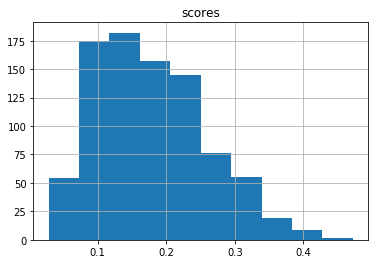

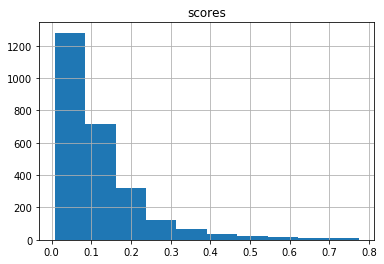

In [122]:
technoDf.hist()
naturalDf.hist()

In [0]:
naturalDf.sort_values("scores").tail(10)

In [0]:
dfFileIndex = naturalDf.set_index("files")
print(dfFileIndex.head())
for dir in os.listdir(TMP_PATH+"content/gdrive/My Drive/aiml/OmdenaMars/data/techno/"):
    print("Scores for:", dir+":")
    for file in os.listdir(TMP_PATH+"content/gdrive/My Drive/aiml/OmdenaMars/data/techno/"+dir):
        print(file,":",dfFileIndex.loc[file].scores)
       

In [0]:
#boostx : ignored this line   dfFileIndex.loc["img_x_11520_y_16512.jpg"]

In [0]:
found = []
notFound = []

#boostx : define a cutOffScore
cutOffScore = 0.001

for img in technoDf[technoDf.scores>cutOffScore].files:
    for dir in os.listdir(TMP_PATH+"content/gdrive/My Drive/aiml/OmdenaMars/data/techno/"):
        if dir not in notFound:
            notFound.append(dir)

for img in technoDf[technoDf.scores>cutOffScore].files:
    for dir in os.listdir(TMP_PATH+"content/gdrive/My Drive/aiml/OmdenaMars/data/techno/"):
        if img in os.listdir(TMP_PATH+"content/gdrive/My Drive/aiml/OmdenaMars/data/techno/"+dir):
            if dir not in found:
                found.append(dir)
                if dir in notFound:
                    notFound.remove(dir)

print("Anomaly detected:",found)
print("Anomaly not-detected:",notFound)